### Predicción de Demanda de Efectivo para Cajeros Automáticos

Se implementa un modelo de predicción de demanda de efectivo para cajeros automáticos en Bogotá, basado en el análisis de datos históricos de transacciones.

### 1.Configuración inicial

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import warnings
from datetime import datetime, timedelta

# Bibliotecas para modelado de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Bibliotecas para aprendizaje automático
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.pipeline import Pipeline

# Configuración para visualización
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener los valores del archivo .env
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

# Cadena de conexión para SQLAlchemy
conn_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(conn_string)

print(f"Conectado a: {db_name} en {db_host}")


Conectado a: atm_optimization en localhost


### 2.Carga y preparación de datos

In [12]:
# Cargar datos de transacciones
try:
    query_transactions = """
    SELECT * FROM transactions
    ORDER BY transaction_date, transaction_time;
    """
    transactions_df = pd.read_sql(query_transactions, engine)
    print(f"Datos de transacciones cargados: {len(transactions_df)} registros")
    
    if len(transactions_df) > 0:
        # Convertir columnas de fecha a datetime
        if 'transaction_date' in transactions_df.columns:
            transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
        
        # display(transactions_df.head())
except Exception as e:
    print(f"Error al cargar transacciones: {e}")
    transactions_df = pd.DataFrame()

# Cargar datos de cajeros
try:
    query_atms = """
    SELECT * FROM atms;
    """
    atms_df = pd.read_sql(query_atms, engine)
    print(f"Datos de cajeros cargados: {len(atms_df)} registros")
    
    if len(atms_df) > 0:
        display(atms_df.head()) # Si se quiere ver la información
except Exception as e:
    print(f"Error al cargar cajeros: {e}")
    atms_df = pd.DataFrame()

Datos de transacciones cargados: 75000 registros
Datos de cajeros cargados: 100 registros


,id,name,location,capacity,cash_type,location_type,min_threshold,max_capacity,assigned_carrier_id
0,ATM001,Cajero Banco Oeste,0101000020E6100000E17CEA58A58052C078D15790662C...,88842521.0,MULTIPROPÓSITO,HOSPITAL,13326378.0,106611025.0,TDV005
1,ATM002,Cajero Centro Comercial Este,0101000020E6100000EA25C632FD8952C075E8F4BC1B2B...,80227437.0,MULTIPROPÓSITO,TRANSPORT,12034115.0,96272924.0,TDV005
2,ATM003,Cajero Centro Comercial Oeste,0101000020E6100000D3DD7536E48752C0F98381E7DE83...,63663448.0,DISPENSADOR,TRANSPORT,9549517.0,76396137.0,TDV003
3,ATM004,Cajero Centro Comercial Este,0101000020E61000009F758D96038352C0F2ECF2AD0F0B...,71409483.0,MULTIPROPÓSITO,MALL,10711422.0,85691379.0,TDV005
4,ATM005,Cajero Centro Comercial Sur,0101000020E6100000172829B0008852C05859DB148F2B...,69156015.0,MULTIPROPÓSITO,OFFICE,10373402.0,82987218.0,TDV004


In [26]:
##### Crear series temporales de demanda por cajero

# Verificar si tenemos los datos necesarios
if len(transactions_df) > 0 and 'atm_id' in transactions_df.columns and 'amount' in transactions_df.columns and 'transaction_date' in transactions_df.columns:
    # Crear series diarias de demanda por cajero
    daily_demand = transactions_df.groupby(['atm_id', 'transaction_date'])['amount'].sum().reset_index()
    daily_demand = daily_demand.rename(columns={'amount': 'daily_demand'})
    
    print(f"Series temporales creadas para {daily_demand['atm_id'].nunique()} cajeros")
    # display(daily_demand.head(10))
    
    # Seleccionar un cajero para análisis detallado
    if len(daily_demand) > 0:
        # Identificar el cajero con más transacciones para análisis detallado
        top_atm = daily_demand.groupby('atm_id').size().sort_values(ascending=False).index[0]
        print(f"Cajero seleccionado para análisis detallado: {top_atm}")
        
        # Filtrar datos para el cajero seleccionado
        top_atm_demand = daily_demand[daily_demand['atm_id'] == top_atm].sort_values('transaction_date')
        
        # Visualizar la serie temporal
        # plt.figure(figsize=(10, 6))
        # plt.plot(top_atm_demand['transaction_date'], top_atm_demand['daily_demand'])
        # plt.title(f'Demanda diaria de efectivo para el cajero {top_atm}')
        # plt.xlabel('Fecha')
        # plt.ylabel('Demanda (monto total)')
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()
else:
    print("No hay suficientes datos para crear series temporales de demanda")
    daily_demand = pd.DataFrame()

Series temporales creadas para 100 cajeros
Cajero seleccionado para análisis detallado: ATM018


Transformaciones aplicadas:
- Rango original: 59,360 a 33,387,373
- Rango logarítmico: 10.99 a 17.32
- Rango normalizado: 0.0018 a 1.0000


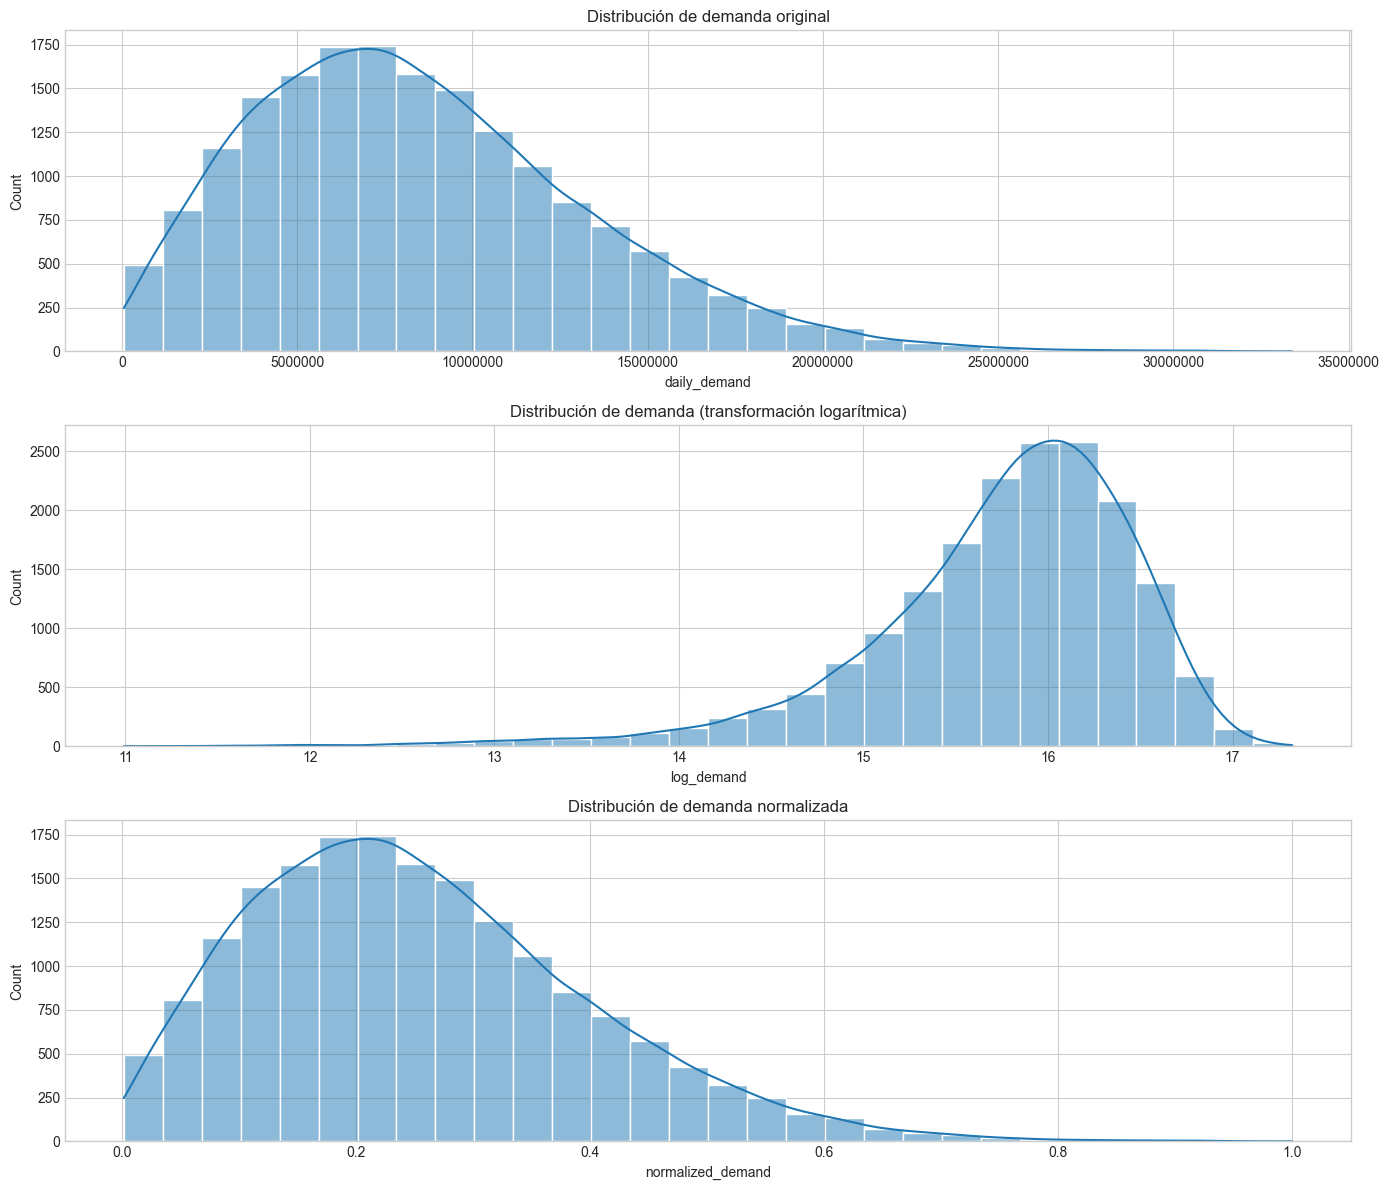

In [45]:
if len(daily_demand) > 0:
    # Crear copia para no afectar otros análisis
    demand_transformed = daily_demand.copy()
    
    # Aplicar transformación logarítmica para comprimir la escala
    # Usamos log1p (log(1+x)) para manejar valores cero
    demand_transformed['log_demand'] = np.log1p(demand_transformed['daily_demand'])
    
    # Normalizar la demanda por el valor máximo
    max_demand = demand_transformed['daily_demand'].max()
    demand_transformed['normalized_demand'] = demand_transformed['daily_demand'] / max_demand
    
    print("Transformaciones aplicadas:")
    print(f"- Rango original: {daily_demand['daily_demand'].min():,.0f} a {daily_demand['daily_demand'].max():,.0f}")
    print(f"- Rango logarítmico: {demand_transformed['log_demand'].min():.2f} a {demand_transformed['log_demand'].max():.2f}")
    print(f"- Rango normalizado: {demand_transformed['normalized_demand'].min():.4f} a {demand_transformed['normalized_demand'].max():.4f}")
    
    # Visualizar las transformaciones
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Demanda original
    sns.histplot(demand_transformed['daily_demand'], bins=30, kde=True, ax=axes[0])
    axes[0].set_title('Distribución de demanda original')
    axes[0].ticklabel_format(style='plain', axis='x')
    
    # Demanda logarítmica
    sns.histplot(demand_transformed['log_demand'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Distribución de demanda (transformación logarítmica)')
    
    # Demanda normalizada
    sns.histplot(demand_transformed['normalized_demand'], bins=30, kde=True, ax=axes[2])
    axes[2].set_title('Distribución de demanda normalizada')
    
    plt.tight_layout()
    plt.show()
    
    # Actualizar la variable daily_demand para incluir las transformaciones
    daily_demand = demand_transformed
else:
    print("No hay suficientes datos para aplicar transformaciones")

In [46]:
if len(daily_demand) > 0:
    # Crear copia para agregar características
    demand_features_advanced = daily_demand.copy()
    
    # Convertir a DataFrame indexado por fecha para facilitar la creación de rezagos
    # Primero agrupar por cajero
    atm_groups = demand_features_advanced.groupby('atm_id')
    
    # Lista para almacenar DataFrames procesados
    processed_dfs = []
    
    for atm_id, group in atm_groups:
        # Ordenar por fecha
        temp_df = group.sort_values('transaction_date').copy()
        
        # Características temporales básicas
        temp_df['day_of_week'] = temp_df['transaction_date'].dt.dayofweek
        temp_df['month'] = temp_df['transaction_date'].dt.month
        temp_df['day'] = temp_df['transaction_date'].dt.day
        temp_df['is_weekend'] = temp_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        
        # Características de quincena y fin de mes
        temp_df['is_first_half'] = temp_df['day'].apply(lambda x: 1 if x <= 15 else 0)
        temp_df['is_month_end'] = temp_df['day'].apply(lambda x: 1 if x >= 25 else 0)
        
        # Crear características de rezago (valores de días anteriores)
        for lag in [1, 2, 3, 7, 14, 30]:
            # Crear rezagos para demanda original
            col_name = f'demand_lag_{lag}'
            temp_df[col_name] = temp_df['daily_demand'].shift(lag)
            
            # Crear rezagos para demanda logarítmica
            log_col_name = f'log_demand_lag_{lag}'
            temp_df[log_col_name] = temp_df['log_demand'].shift(lag)
            
            # Crear rezagos para demanda normalizada
            norm_col_name = f'norm_demand_lag_{lag}'
            temp_df[norm_col_name] = temp_df['normalized_demand'].shift(lag)
        
        # Crear medias móviles
        for window in [3, 7, 14]:
            # Media móvil para demanda original
            col_name = f'demand_ma_{window}'
            temp_df[col_name] = temp_df['daily_demand'].rolling(window=window).mean()
            
            # Media móvil para demanda logarítmica
            log_col_name = f'log_demand_ma_{window}'
            temp_df[log_col_name] = temp_df['log_demand'].rolling(window=window).mean()
            
            # Media móvil para demanda normalizada
            norm_col_name = f'norm_demand_ma_{window}'
            temp_df[norm_col_name] = temp_df['normalized_demand'].rolling(window=window).mean()
        
        # Agregar al resultado
        processed_dfs.append(temp_df)
    
    # Combinar todos los DataFrames procesados
    demand_features_advanced = pd.concat(processed_dfs)
    
    # Eliminar filas con valores NaN (primeras filas que no tienen rezagos)
    demand_features_advanced = demand_features_advanced.dropna()
    
    print(f"Características avanzadas creadas. Filas restantes: {len(demand_features_advanced)}")
    print(f"Columnas disponibles: {demand_features_advanced.columns.tolist()}")
    
    # Actualizar la variable de características
    demand_features = demand_features_advanced
else:
    print("No hay suficientes datos para crear características avanzadas")

Características avanzadas creadas. Filas restantes: 15003
Columnas disponibles: ['atm_id', 'transaction_date', 'daily_demand', 'log_demand', 'normalized_demand', 'day_of_week', 'month', 'day', 'is_weekend', 'is_first_half', 'is_month_end', 'demand_lag_1', 'log_demand_lag_1', 'norm_demand_lag_1', 'demand_lag_2', 'log_demand_lag_2', 'norm_demand_lag_2', 'demand_lag_3', 'log_demand_lag_3', 'norm_demand_lag_3', 'demand_lag_7', 'log_demand_lag_7', 'norm_demand_lag_7', 'demand_lag_14', 'log_demand_lag_14', 'norm_demand_lag_14', 'demand_lag_30', 'log_demand_lag_30', 'norm_demand_lag_30', 'demand_ma_3', 'log_demand_ma_3', 'norm_demand_ma_3', 'demand_ma_7', 'log_demand_ma_7', 'norm_demand_ma_7', 'demand_ma_14', 'log_demand_ma_14', 'norm_demand_ma_14']


Cajero seleccionado para análisis detallado: ATM018
Datos de entrenamiento: 122 registros
Datos de prueba: 31 registros


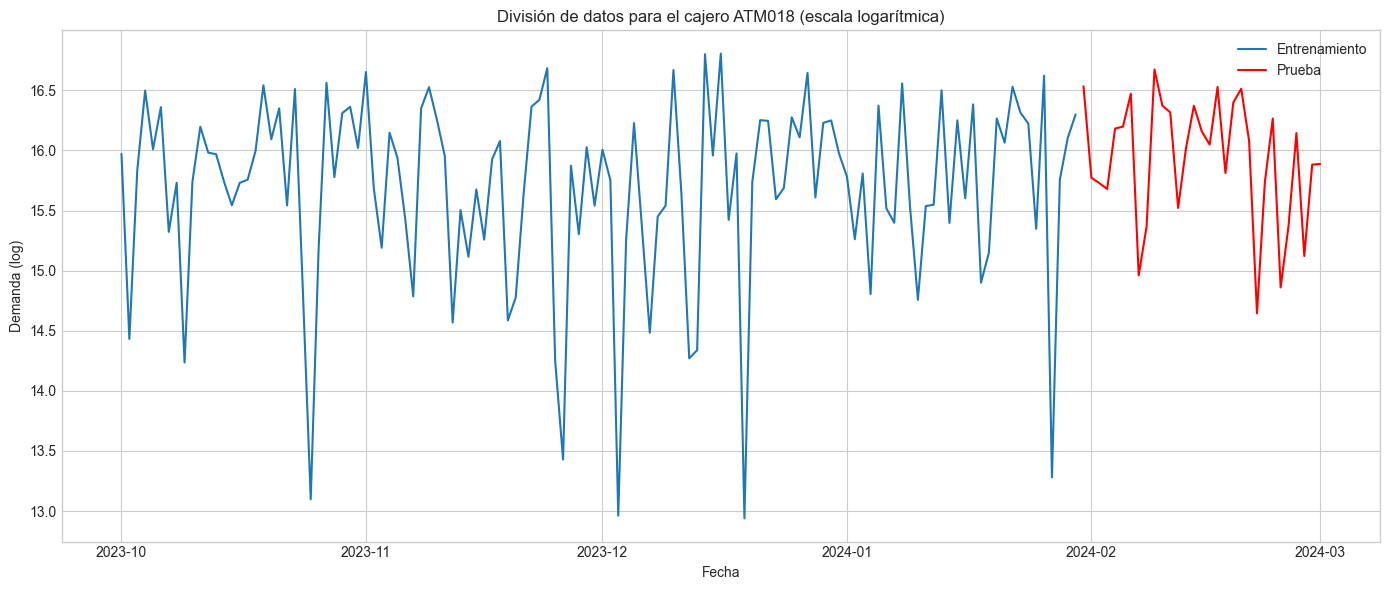

In [47]:
######### Dividir datos para entrenamiento y prueba

if len(demand_features) > 0:
    # Seleccionar el cajero con más datos para análisis
    atm_counts = demand_features.groupby('atm_id').size()
    if len(atm_counts) > 0:
        top_atm = atm_counts.sort_values(ascending=False).index[0]
        print(f"Cajero seleccionado para análisis detallado: {top_atm}")
        
        # Filtrar datos para el cajero seleccionado
        top_atm_features = demand_features[demand_features['atm_id'] == top_atm].copy()
        top_atm_features = top_atm_features.sort_values('transaction_date').reset_index(drop=True)
        
        # Verificar si hay suficientes datos
        if len(top_atm_features) >= 10:  # Al menos 10 registros para hacer un split razonable
            # Determinar punto de corte para división de datos (80% entrenamiento, 20% prueba)
            split_idx = int(len(top_atm_features) * 0.8)
            
            # Dividir los datos
            train_data = top_atm_features.iloc[:split_idx].copy()
            test_data = top_atm_features.iloc[split_idx:].copy()
            
            print(f"Datos de entrenamiento: {len(train_data)} registros")
            print(f"Datos de prueba: {len(test_data)} registros")
            
            # Visualizar la división (usando demanda logarítmica para mejor visualización)
            plt.figure(figsize=(14, 6))
            plt.plot(train_data['transaction_date'], train_data['log_demand'], label='Entrenamiento')
            plt.plot(test_data['transaction_date'], test_data['log_demand'], label='Prueba', color='red')
            plt.title(f'División de datos para el cajero {top_atm} (escala logarítmica)')
            plt.xlabel('Fecha')
            plt.ylabel('Demanda (log)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No hay suficientes datos para el cajero {top_atm}")
    else:
        print("No se encontraron cajeros con datos suficientes")
else:
    print("No hay datos para dividir en conjuntos de entrenamiento y prueba")

### 3. Analisis de series temporales

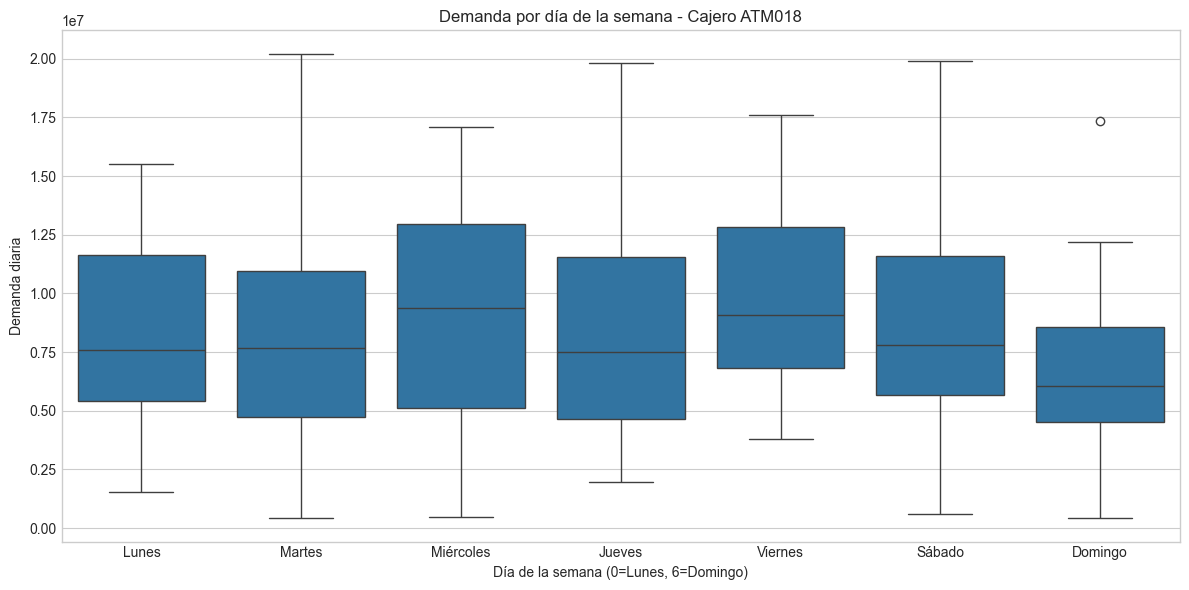

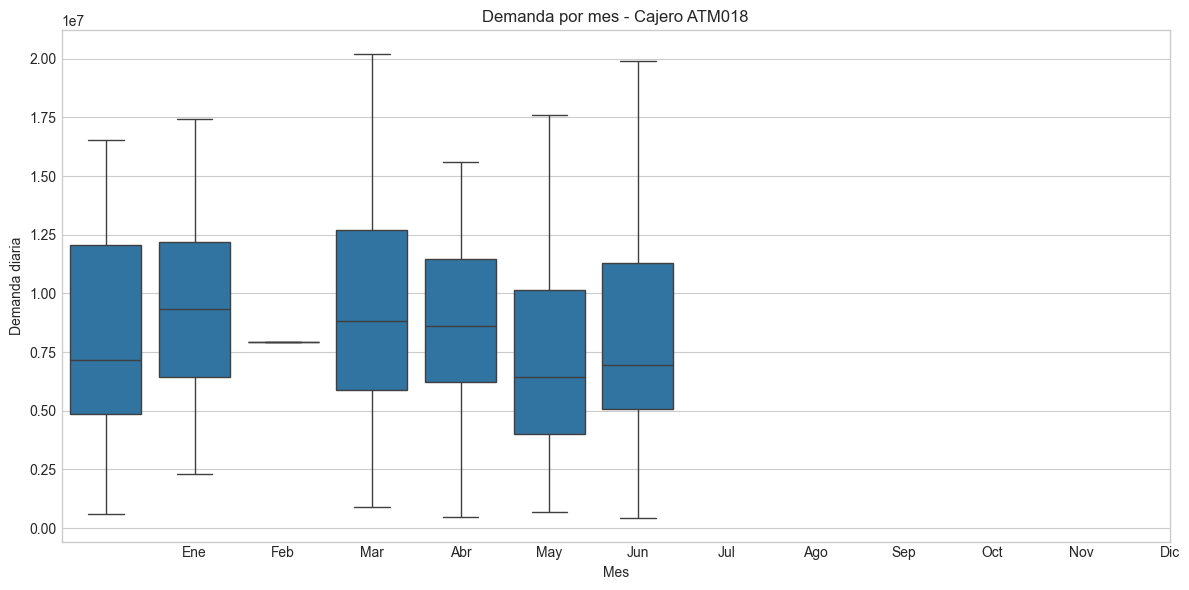

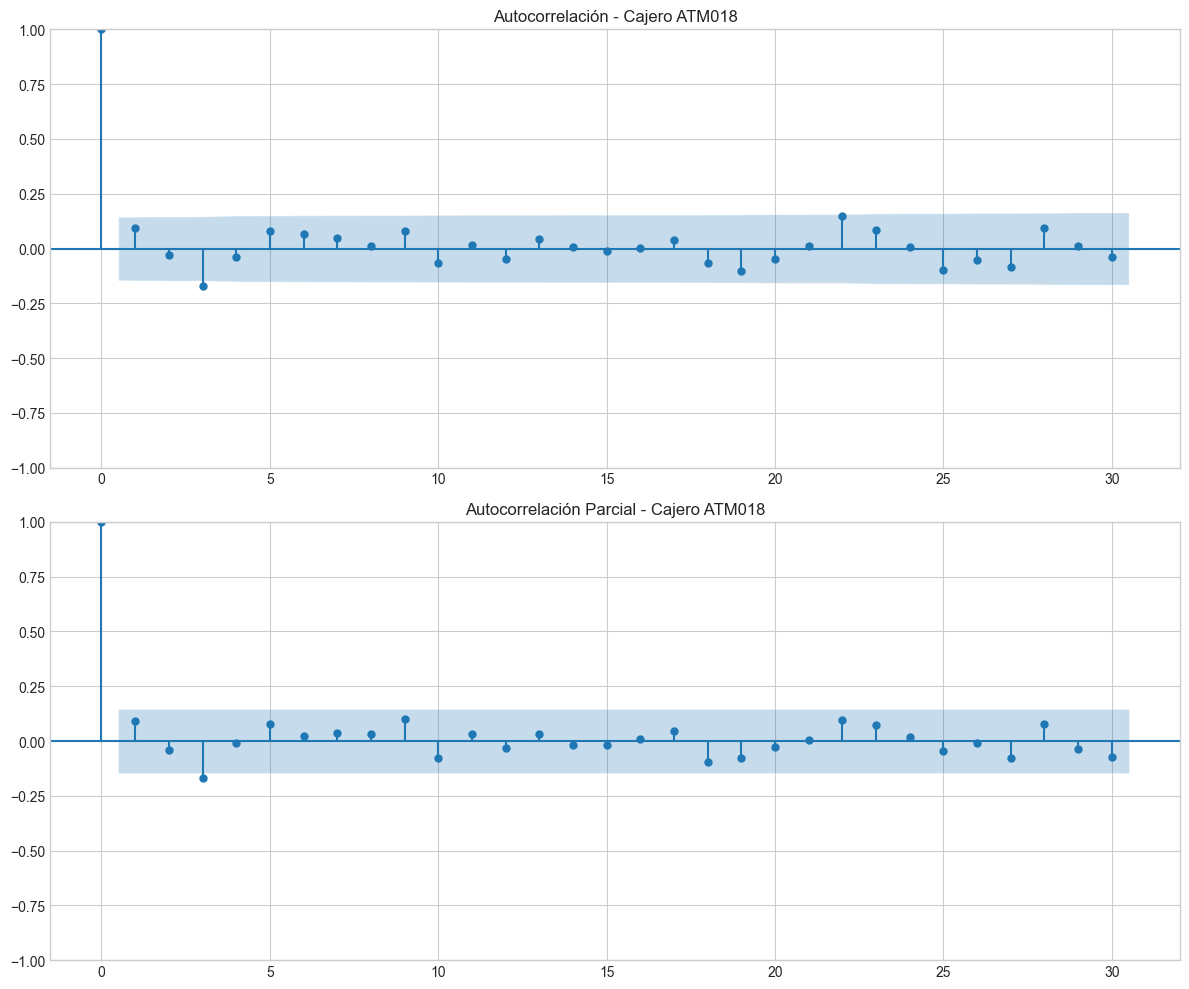

In [30]:
##### Patrones temporales de demanda

if len(top_atm_features) > 0:
    # Analizar patrones por día de la semana
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='day_of_week', y='daily_demand', data=top_atm_features)
    plt.title(f'Demanda por día de la semana - Cajero {top_atm}')
    plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
    plt.ylabel('Demanda diaria')
    plt.xticks(range(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
    plt.tight_layout()
    plt.show()
    
    # Analizar patrones por mes
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='month', y='daily_demand', data=top_atm_features)
    plt.title(f'Demanda por mes - Cajero {top_atm}')
    plt.xlabel('Mes')
    plt.ylabel('Demanda diaria')
    plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    plt.tight_layout()
    plt.show()
    
    # Autocorrelación para identificar patrones
    try:
        # Configurar la serie temporal con índice de fecha
        ts_data = top_atm_features.set_index('transaction_date')['daily_demand']
        
        # Graficar autocorrelación para identificar patrones
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        plot_acf(ts_data, ax=ax1, lags=30)
        ax1.set_title(f'Autocorrelación - Cajero {top_atm}')
        
        plot_pacf(ts_data, ax=ax2, lags=30)
        ax2.set_title(f'Autocorrelación Parcial - Cajero {top_atm}')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error al calcular autocorrelación: {e}")
        print("Continuando con el análisis...")
else:
    print("No hay datos suficientes para analizar patrones temporales")

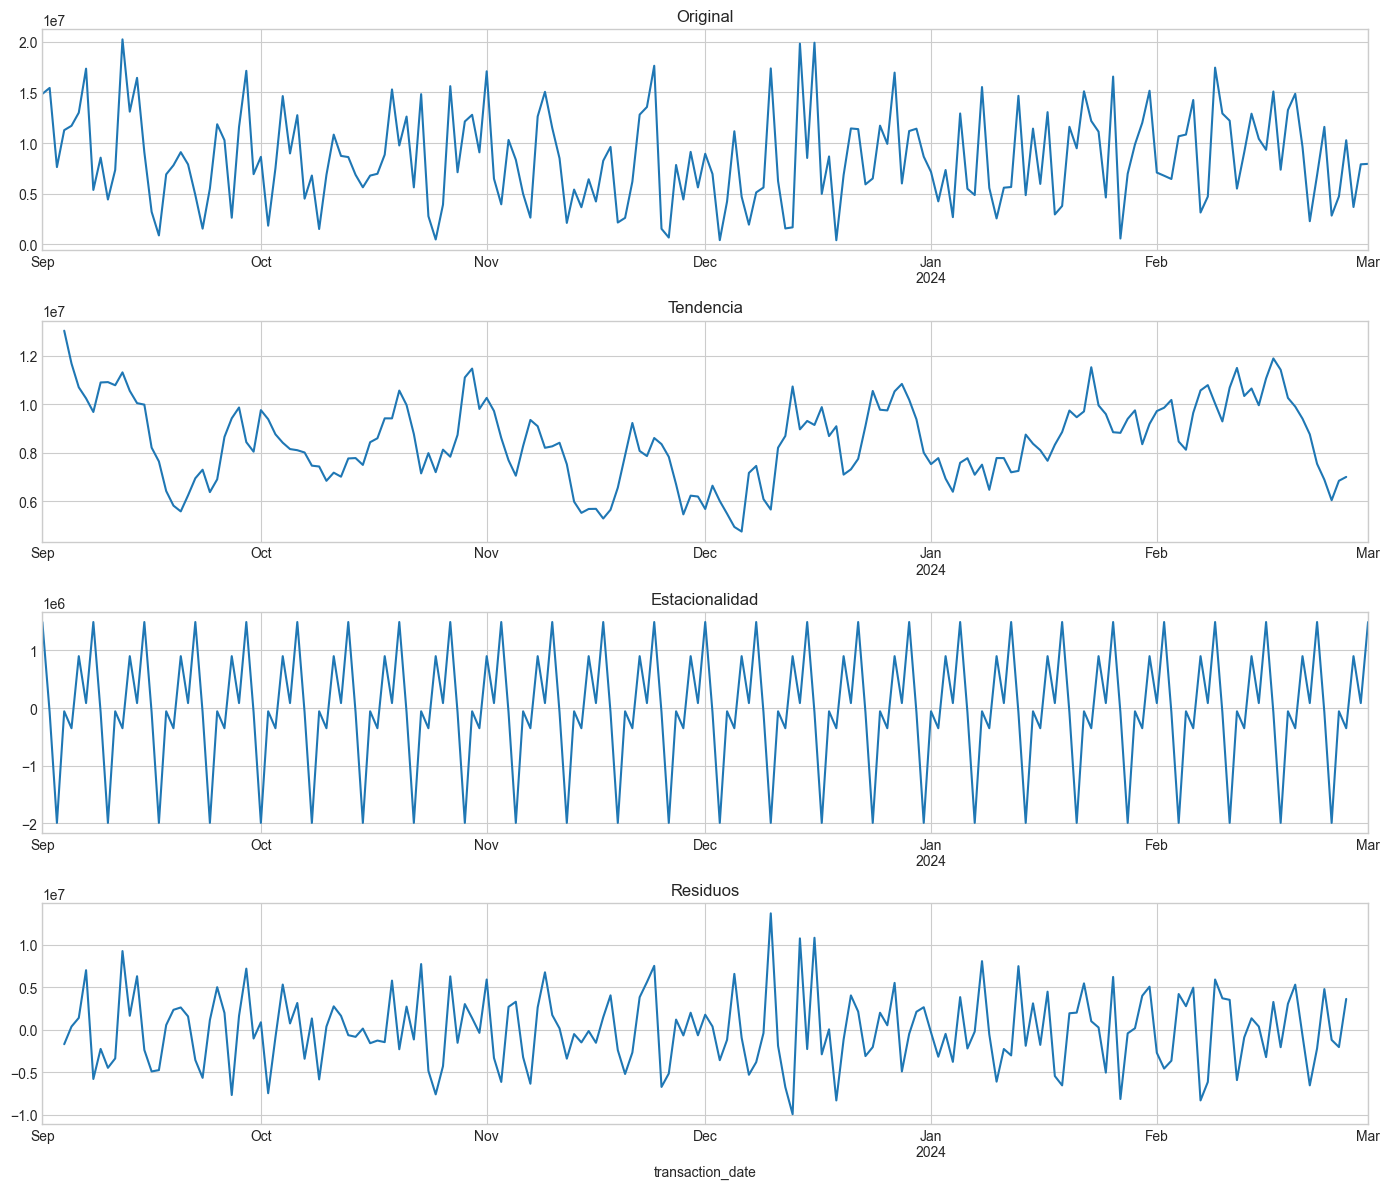

In [31]:
########### Descomposición de series temporales

if len(top_atm_features) > 10:  # Necesitamos suficientes datos para la descomposición
    try:
        # Configurar la serie temporal con índice de fecha
        ts_data = top_atm_features.set_index('transaction_date')['daily_demand']
        
        # Verificar si hay datos suficientes y si los datos están completos
        if len(ts_data) > 14:  # Al menos dos semanas de datos
            # Rellenar valores faltantes si los hay
            ts_data = ts_data.asfreq('D', method='ffill')
            
            # Descomponer la serie temporal
            decomposition = seasonal_decompose(ts_data, model='additive', period=7)
            
            # Visualizar la descomposición
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
            decomposition.observed.plot(ax=ax1)
            ax1.set_title('Original')
            ax1.set_xlabel('')
            
            decomposition.trend.plot(ax=ax2)
            ax2.set_title('Tendencia')
            ax2.set_xlabel('')
            
            decomposition.seasonal.plot(ax=ax3)
            ax3.set_title('Estacionalidad')
            ax3.set_xlabel('')
            
            decomposition.resid.plot(ax=ax4)
            ax4.set_title('Residuos')
            
            plt.tight_layout()
            plt.show()
        else:
            print("No hay suficientes datos para la descomposición de series temporales")
    except Exception as e:
        print(f"Error en la descomposición de series temporales: {e}")
        print("Continuando con el análisis...")
else:
    print("No hay datos suficientes para descomposición de series temporales")

### 4.Modelado básico - Modelo de línea base

Modelo ingenuo (promedio histórico):
MAE: 3612204.88
RMSE: 4299461.45


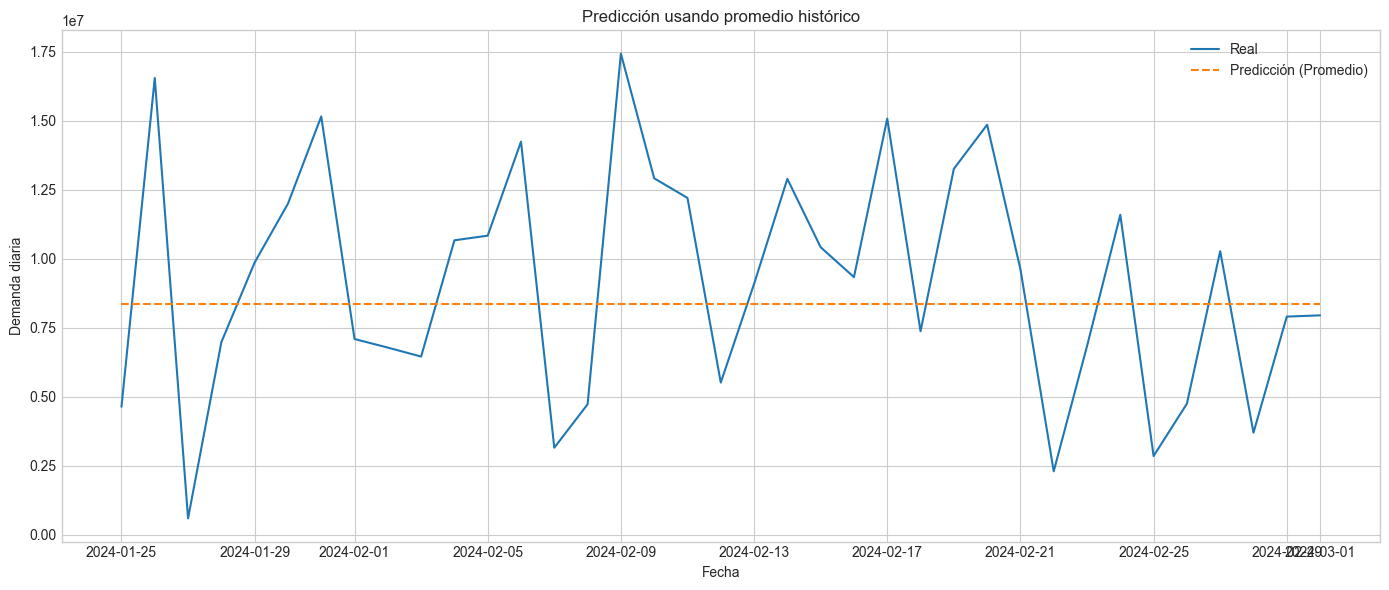

In [32]:
# ### 4.1 Método ingenuo (promedio histórico)

# %%
if len(train_data) > 0 and len(test_data) > 0:
    # Modelo ingenuo: usar el promedio histórico como predicción
    naive_pred = train_data['daily_demand'].mean()
    
    # Aplicar predicción a los datos de prueba
    naive_predictions = [naive_pred] * len(test_data)
    
    # Calcular errores
    naive_mae = mean_absolute_error(test_data['daily_demand'], naive_predictions)
    naive_rmse = np.sqrt(mean_squared_error(test_data['daily_demand'], naive_predictions))
    
    print(f"Modelo ingenuo (promedio histórico):")
    print(f"MAE: {naive_mae:.2f}")
    print(f"RMSE: {naive_rmse:.2f}")
    
    # Visualizar predicciones
    plt.figure(figsize=(14, 6))
    plt.plot(test_data['transaction_date'], test_data['daily_demand'], label='Real')
    plt.plot(test_data['transaction_date'], naive_predictions, label='Predicción (Promedio)', linestyle='--')
    plt.title('Predicción usando promedio histórico')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda diaria')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para modelado básico")

Modelo ARIMA:
MAE: 3981508.96
RMSE: 4822209.95


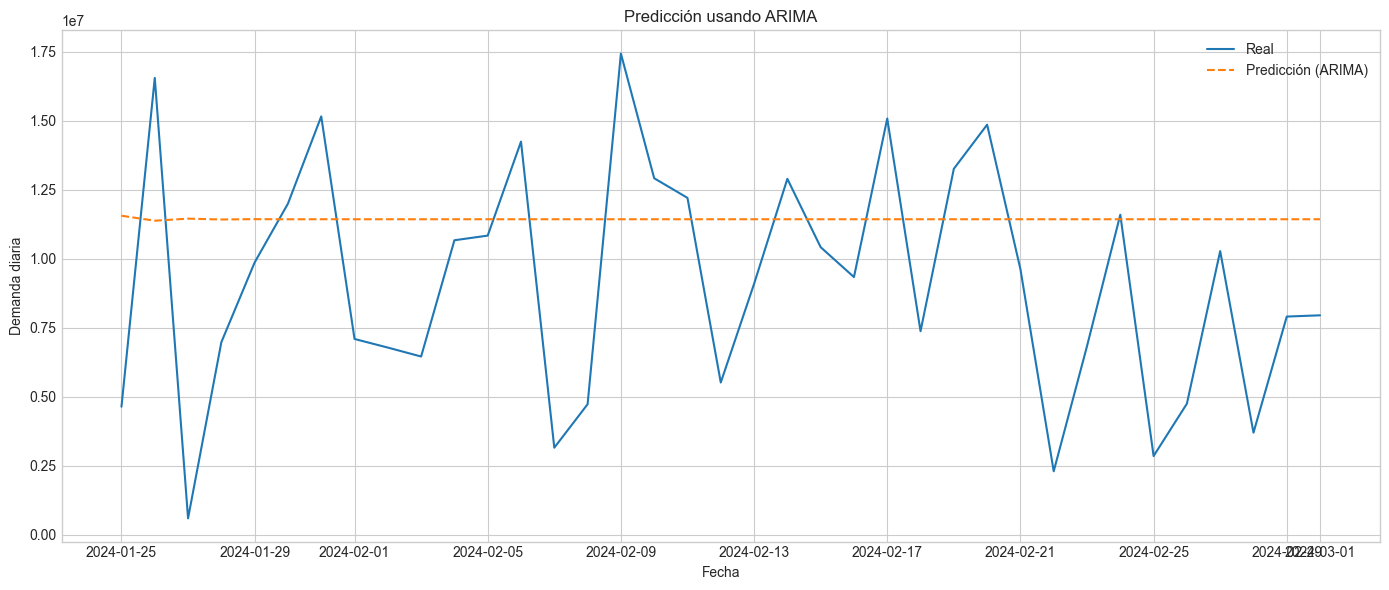

In [34]:
##### Modelo ARIMA

# %%
if len(train_data) > 10:  # Necesitamos suficientes datos para ARIMA
    try:
        # Preparar datos para ARIMA
        train_ts = train_data.set_index('transaction_date')['daily_demand']
        test_ts = test_data.set_index('transaction_date')['daily_demand']
        
        # Entrenar modelo ARIMA
        # Parámetros: p=1 (AR), d=1 (diferenciación), q=0 (MA)
        arima_model = ARIMA(train_ts, order=(1, 1, 0))
        arima_results = arima_model.fit()
        
        # Realizar predicciones
        arima_predictions = arima_results.forecast(steps=len(test_ts))
        
        # Calcular errores
        arima_mae = mean_absolute_error(test_ts, arima_predictions)
        arima_rmse = np.sqrt(mean_squared_error(test_ts, arima_predictions))
        
        print(f"Modelo ARIMA:")
        print(f"MAE: {arima_mae:.2f}")
        print(f"RMSE: {arima_rmse:.2f}")
        
        # Visualizar predicciones
        plt.figure(figsize=(14, 6))
        plt.plot(test_ts.index, test_ts, label='Real')
        plt.plot(test_ts.index, arima_predictions, label='Predicción (ARIMA)', linestyle='--')
        plt.title('Predicción usando ARIMA')
        plt.xlabel('Fecha')
        plt.ylabel('Demanda diaria')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error en modelado ARIMA: {e}")
        print("Continuando con análisis de aprendizaje automático...")
else:
    print("No hay datos suficientes para modelado ARIMA")

### 5.Modelado avanzado con aprendizaje automático

In [48]:
### Preparación de características

if len(train_data) > 0 and len(test_data) > 0:
    # Definir características a utilizar (incluyendo las nuevas)
    feature_columns = [
        # Características de calendario
        'day_of_week', 'month', 'day', 'is_weekend', 'is_first_half', 'is_month_end',
        
        # Rezagos de demanda (logarítmica mejor para modelado)
        'log_demand_lag_1', 'log_demand_lag_7', 'log_demand_lag_14',
        
        # Medias móviles (también en escala logarítmica)
        'log_demand_ma_7'
    ]
    
    # Verificar que todas las columnas estén disponibles
    available_columns = [col for col in feature_columns if col in train_data.columns]
    
    if len(available_columns) > 0:
        # Preparar datasets de entrenamiento y prueba
        X_train = train_data[available_columns].copy()
        # Usaremos la demanda logarítmica como objetivo
        y_train = train_data['log_demand'].values
        
        X_test = test_data[available_columns].copy()
        y_test = test_data['log_demand'].values
        
        # También guardar los valores originales para evaluación
        y_train_original = train_data['daily_demand'].values
        y_test_original = test_data['daily_demand'].values
        
        # Normalizar características
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print("Características preparadas para modelado:")
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"Columnas utilizadas: {available_columns}")
    else:
        print("No hay columnas de características disponibles")
else:
    print("No hay datos suficientes para preparar características")

Características preparadas para modelado:
X_train shape: (122, 10)
X_test shape: (31, 10)
Columnas utilizadas: ['day_of_week', 'month', 'day', 'is_weekend', 'is_first_half', 'is_month_end', 'log_demand_lag_1', 'log_demand_lag_7', 'log_demand_lag_14', 'log_demand_ma_7']


Modelo Random Forest:
MAE (log): 0.4272
RMSE (log): 0.5356
R² (log): -0.0552
MAPE: 48.05%
Precisión: 51.95%


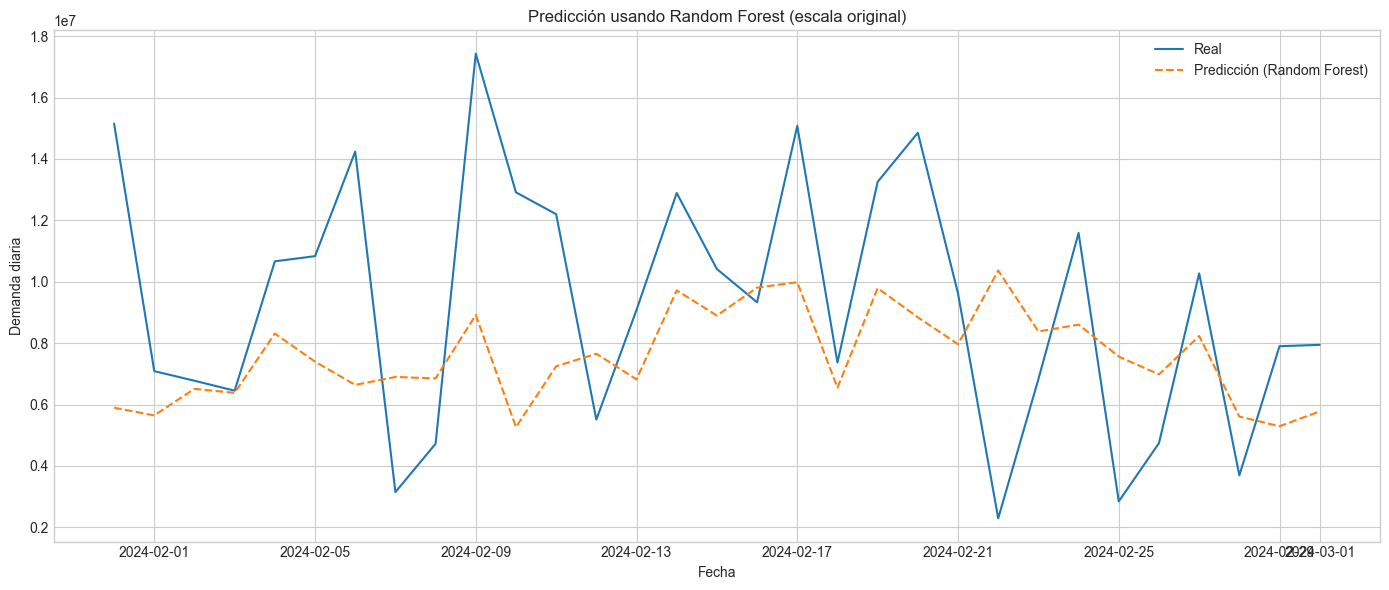

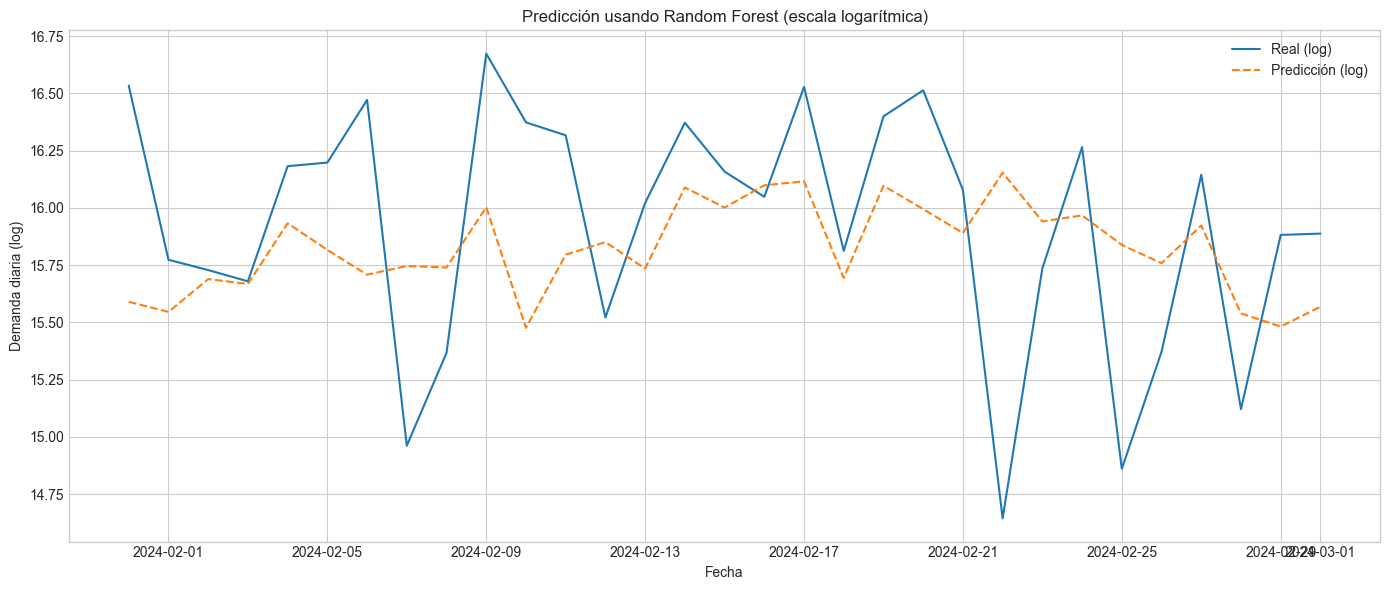

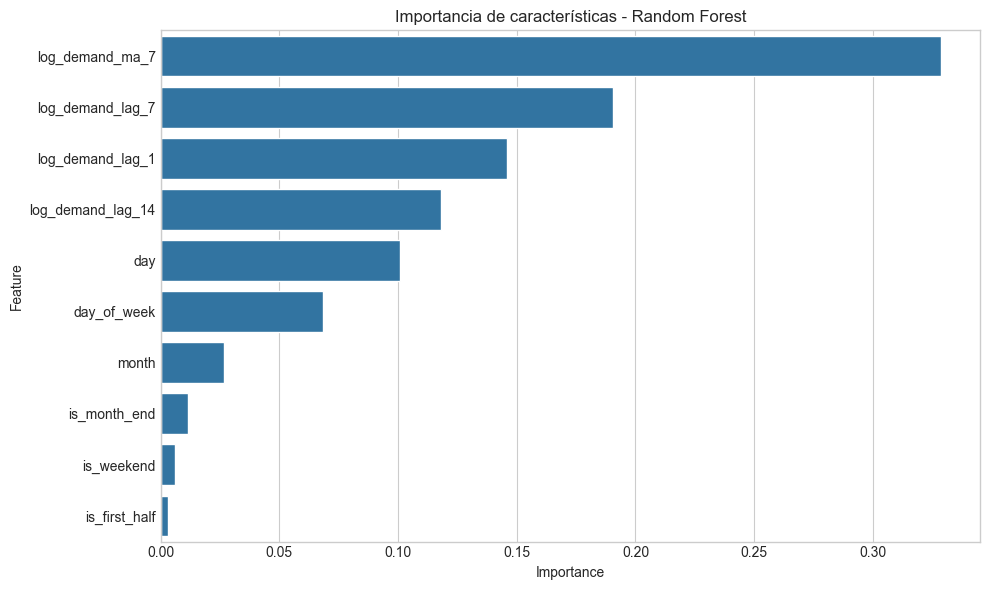

In [49]:
#### Random Forest

if 'X_train_scaled' in locals() and len(X_train_scaled) > 0:
    # Entrenar modelo Random Forest con la demanda logarítmica
    rf_model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    rf_model.fit(X_train_scaled, y_train)
    
    # Realizar predicciones (en escala logarítmica)
    rf_predictions_log = rf_model.predict(X_test_scaled)
    
    # Convertir predicciones a escala original
    rf_predictions = np.expm1(rf_predictions_log)  # Inversa de log1p
    
    # Calcular errores en escala logarítmica
    rf_mae_log = mean_absolute_error(y_test, rf_predictions_log)
    rf_rmse_log = np.sqrt(mean_squared_error(y_test, rf_predictions_log))
    rf_r2_log = r2_score(y_test, rf_predictions_log)
    
    # Calcular errores en escala original para referencia
    rf_mae = mean_absolute_error(y_test_original, rf_predictions)
    rf_rmse = np.sqrt(mean_squared_error(y_test_original, rf_predictions))
    rf_r2 = r2_score(y_test_original, rf_predictions)
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    rf_mape = np.mean(np.abs((y_test_original - rf_predictions) / y_test_original)) * 100
    
    # Calcular precisión basada en MAPE
    rf_accuracy = max(0, 100 - rf_mape)
    
    print(f"Modelo Random Forest:")
    print(f"MAE (log): {rf_mae_log:.4f}")
    print(f"RMSE (log): {rf_rmse_log:.4f}")
    print(f"R² (log): {rf_r2_log:.4f}")
    print(f"MAPE: {rf_mape:.2f}%")
    print(f"Precisión: {rf_accuracy:.2f}%")
    
    # Visualizar predicciones en escala original
    plt.figure(figsize=(14, 6))
    plt.plot(test_data['transaction_date'], y_test_original, label='Real')
    plt.plot(test_data['transaction_date'], rf_predictions, label='Predicción (Random Forest)', linestyle='--')
    plt.title('Predicción usando Random Forest (escala original)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda diaria')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Visualizar predicciones en escala logarítmica
    plt.figure(figsize=(14, 6))
    plt.plot(test_data['transaction_date'], y_test, label='Real (log)')
    plt.plot(test_data['transaction_date'], rf_predictions_log, label='Predicción (log)', linestyle='--')
    plt.title('Predicción usando Random Forest (escala logarítmica)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda diaria (log)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Analizar importancia de características
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Importancia de características - Random Forest')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para modelado Random Forest")

Modelo XGBoost:
MAE (log): 0.4616
RMSE (log): 0.5736
R² (log): -0.2103
MAPE: 51.31%
Precisión: 48.69%


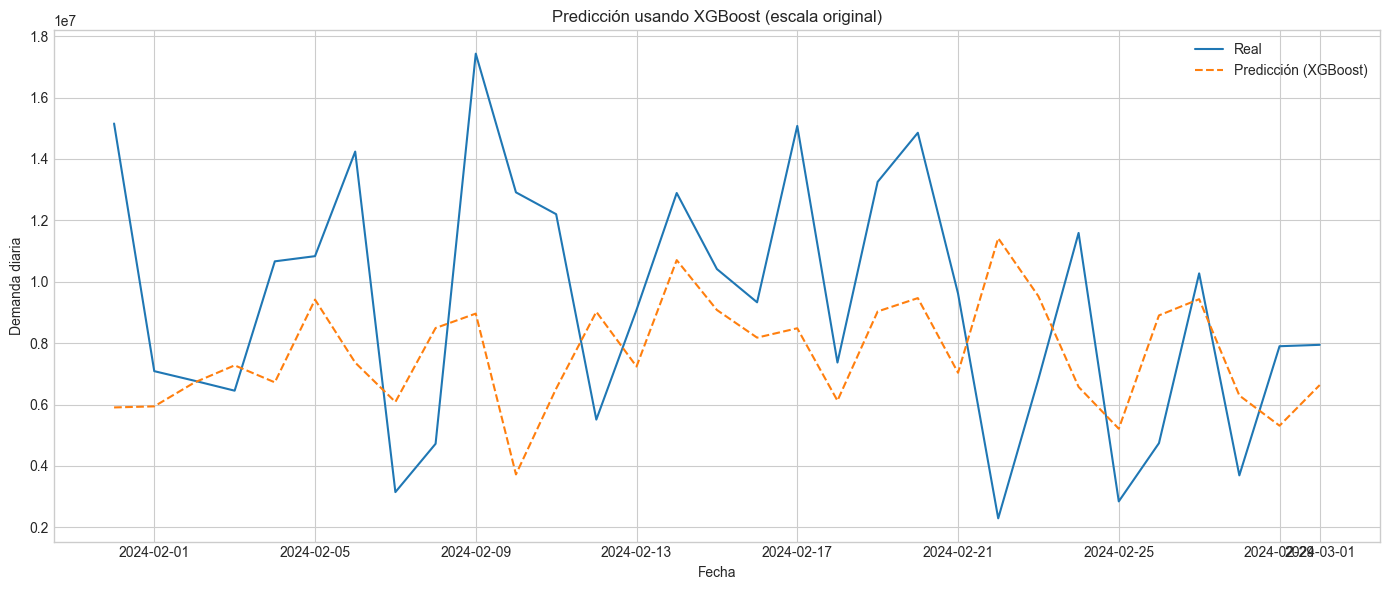

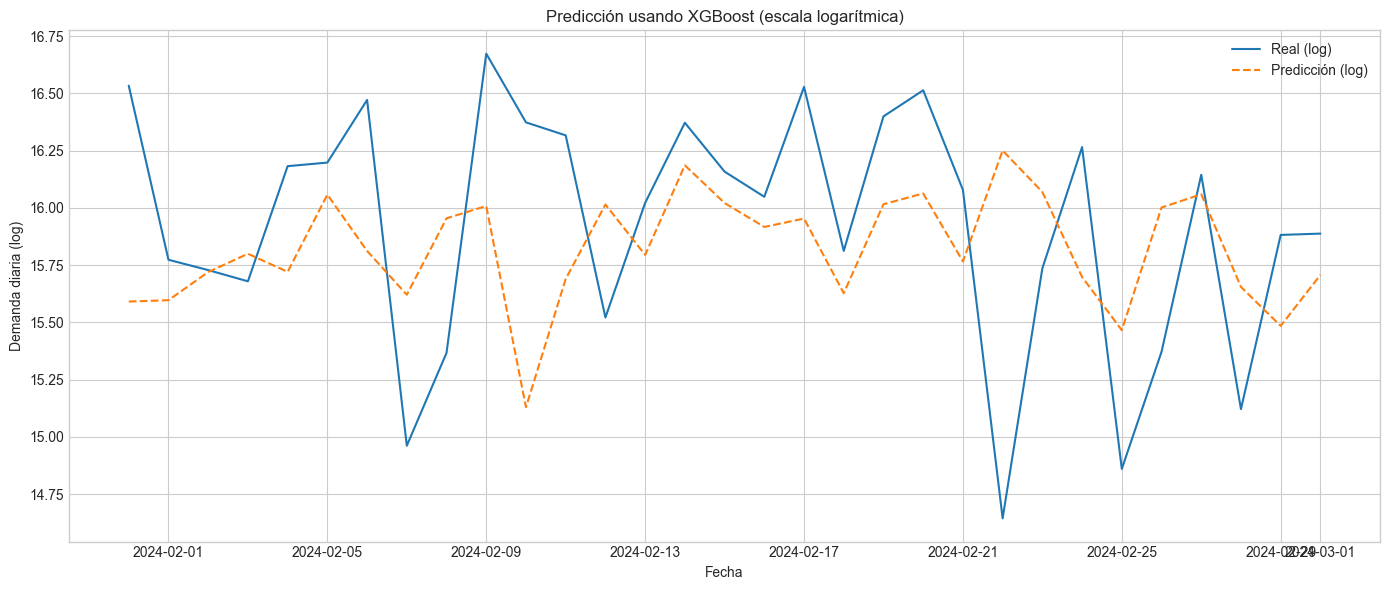

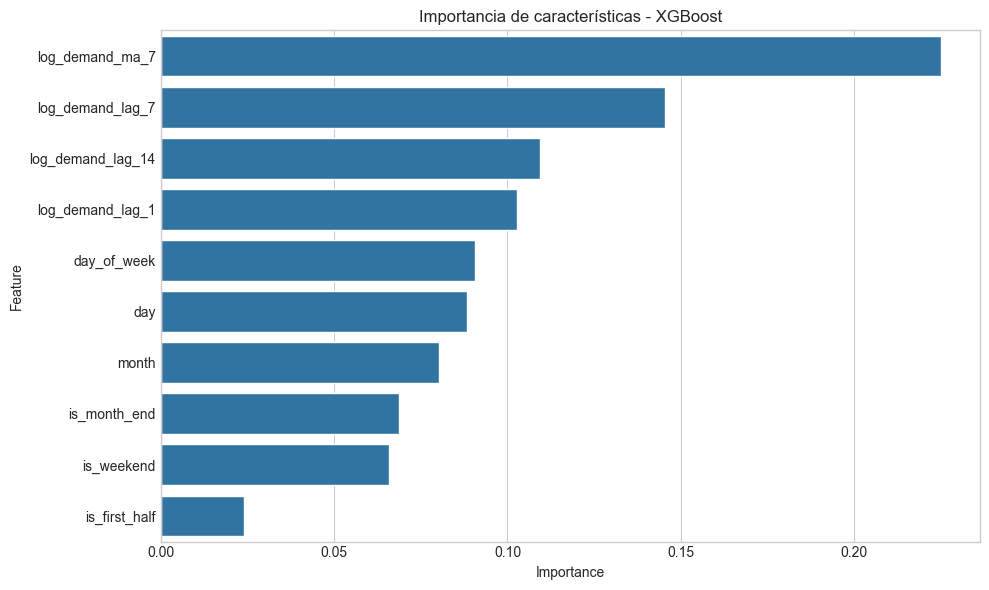

In [50]:
### XGBoost
if 'X_train_scaled' in locals() and len(X_train_scaled) > 0:
    # Entrenar modelo XGBoost con parámetros ajustados
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        random_state=42
    )
    xgb_model.fit(X_train_scaled, y_train)
    
    # Realizar predicciones (en escala logarítmica)
    xgb_predictions_log = xgb_model.predict(X_test_scaled)
    
    # Convertir predicciones a escala original
    xgb_predictions = np.expm1(xgb_predictions_log)
    
    # Calcular errores en escala logarítmica
    xgb_mae_log = mean_absolute_error(y_test, xgb_predictions_log)
    xgb_rmse_log = np.sqrt(mean_squared_error(y_test, xgb_predictions_log))
    xgb_r2_log = r2_score(y_test, xgb_predictions_log)
    
    # Calcular errores en escala original para referencia
    xgb_mae = mean_absolute_error(y_test_original, xgb_predictions)
    xgb_rmse = np.sqrt(mean_squared_error(y_test_original, xgb_predictions))
    xgb_r2 = r2_score(y_test_original, xgb_predictions)
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    xgb_mape = np.mean(np.abs((y_test_original - xgb_predictions) / y_test_original)) * 100
    
    # Calcular precisión basada en MAPE
    xgb_accuracy = max(0, 100 - xgb_mape)
    
    print(f"Modelo XGBoost:")
    print(f"MAE (log): {xgb_mae_log:.4f}")
    print(f"RMSE (log): {xgb_rmse_log:.4f}")
    print(f"R² (log): {xgb_r2_log:.4f}")
    print(f"MAPE: {xgb_mape:.2f}%")
    print(f"Precisión: {xgb_accuracy:.2f}%")
    
    # Visualizar predicciones
    plt.figure(figsize=(14, 6))
    plt.plot(test_data['transaction_date'], y_test_original, label='Real')
    plt.plot(test_data['transaction_date'], xgb_predictions, label='Predicción (XGBoost)', linestyle='--')
    plt.title('Predicción usando XGBoost (escala original)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda diaria')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Visualizar predicciones en escala logarítmica
    plt.figure(figsize=(14, 6))
    plt.plot(test_data['transaction_date'], y_test, label='Real (log)')
    plt.plot(test_data['transaction_date'], xgb_predictions_log, label='Predicción (log)', linestyle='--')
    plt.title('Predicción usando XGBoost (escala logarítmica)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda diaria (log)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Analizar importancia de características
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Importancia de características - XGBoost')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para modelado XGBoost")

### 6.Optimización de Hiperparametros

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Mejores parámetros encontrados:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Mejor modelo XGBoost optimizado:
MAE (log): 0.4505
RMSE (log): 0.5439
R² (log): -0.0882
MAPE: 47.36%
Precisión: 52.64%


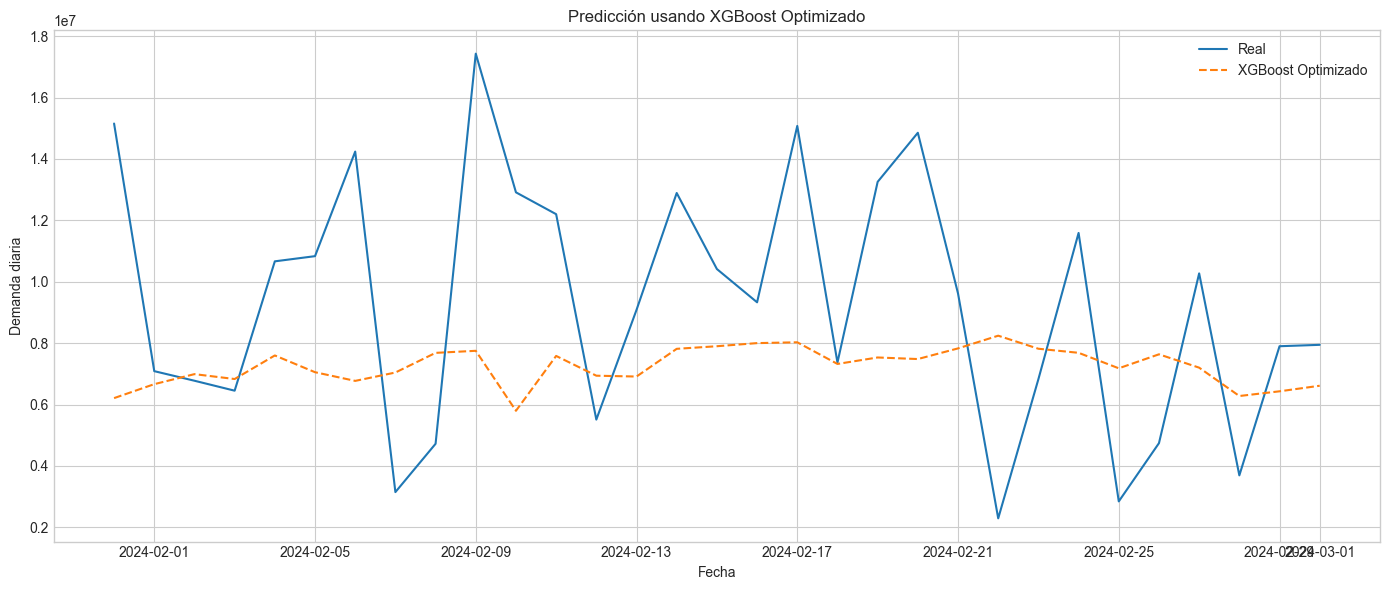

In [51]:
if 'X_train_scaled' in locals() and len(X_train_scaled) > 0:
    # Definir espacio de búsqueda más adecuado para XGBoost
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'gamma': [0, 0.1]
    }
    
    # Configurar validación cruzada de series temporales
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Configurar búsqueda de cuadrícula más eficiente
    grid_search = GridSearchCV(
        estimator=xgb.XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    
    try:
        # Ejecutar búsqueda (puede tomar tiempo)
        grid_search.fit(X_train_scaled, y_train)
        
        # Mejores parámetros
        print("Mejores parámetros encontrados:")
        print(grid_search.best_params_)
        
        # Evaluar el mejor modelo
        best_model = grid_search.best_estimator_
        best_predictions_log = best_model.predict(X_test_scaled)
        
        # Convertir a escala original
        best_predictions = np.expm1(best_predictions_log)
        
        # Calcular errores en escala logarítmica
        best_mae_log = mean_absolute_error(y_test, best_predictions_log)
        best_rmse_log = np.sqrt(mean_squared_error(y_test, best_predictions_log))
        best_r2_log = r2_score(y_test, best_predictions_log)
        
        # Calcular MAPE
        best_mape = np.mean(np.abs((y_test_original - best_predictions) / y_test_original)) * 100
        
        # Calcular precisión basada en MAPE
        best_accuracy = max(0, 100 - best_mape)
        
        print(f"Mejor modelo XGBoost optimizado:")
        print(f"MAE (log): {best_mae_log:.4f}")
        print(f"RMSE (log): {best_rmse_log:.4f}")
        print(f"R² (log): {best_r2_log:.4f}")
        print(f"MAPE: {best_mape:.2f}%")
        print(f"Precisión: {best_accuracy:.2f}%")
        
        # Visualizar predicciones
        plt.figure(figsize=(14, 6))
        plt.plot(test_data['transaction_date'], y_test_original, label='Real')
        plt.plot(test_data['transaction_date'], best_predictions, label='XGBoost Optimizado', linestyle='--')
        plt.title('Predicción usando XGBoost Optimizado')
        plt.xlabel('Fecha')
        plt.ylabel('Demanda diaria')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error en optimización de hiperparámetros: {e}")
        print("Continuando con la evaluación de modelos...")
else:
    print("No hay datos suficientes para optimización de hiperparámetros")

### Comparación de modelos y evaluación final

Comparación de modelos:


,MAE,RMSE,MAE (log),RMSE (log),R²,MAPE (%),Precisión (%)
XGBoost Optimizado,3.663927e+06,4.504218e+06,0.450519,0.543858,-0.257967,47.364100,52.635900
Random Forest,3.430095e+06,4.249865e+06,0.427192,0.535561,-0.119904,48.045714,51.954286
XGBoost,3.687941e+06,4.544838e+06,0.461632,0.573571,-0.280759,51.307877,48.692123


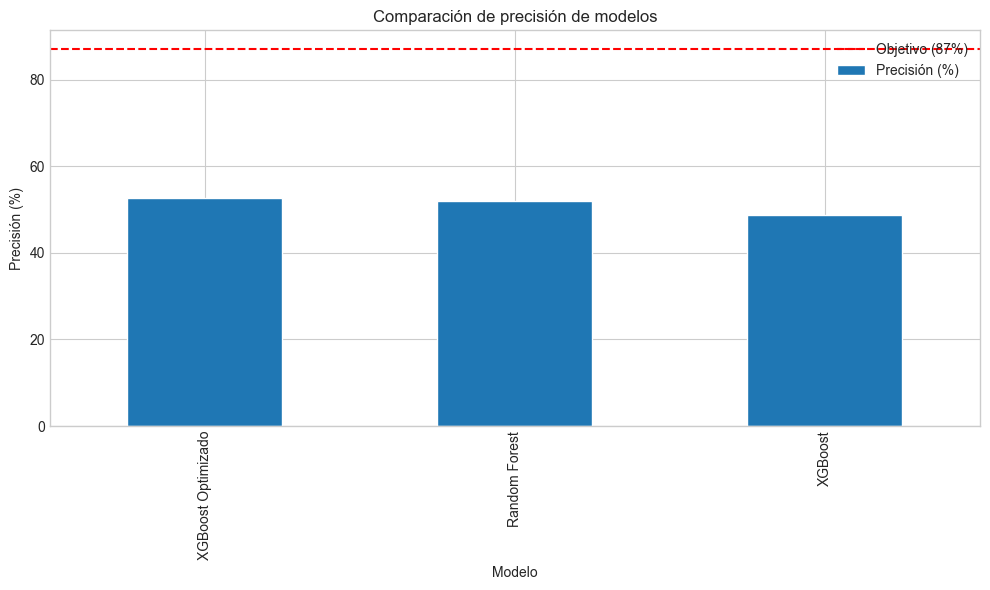

In [54]:
models_comparison = {}

# Agregar otros modelos a la comparación según se hayan ejecutado
if 'xgb_accuracy' in locals():
    models_comparison['XGBoost'] = {
        'MAE': xgb_mae,
        'RMSE': xgb_rmse,
        'MAE (log)': xgb_mae_log,
        'RMSE (log)': xgb_rmse_log,
        'R²': xgb_r2,
        'MAPE (%)': xgb_mape,
        'Precisión (%)': xgb_accuracy
    }

if 'rf_accuracy' in locals():
    models_comparison['Random Forest'] = {
        'MAE': rf_mae,
        'RMSE': rf_rmse,
        'MAE (log)': rf_mae_log,
        'RMSE (log)': rf_rmse_log,
        'R²': rf_r2,
        'MAPE (%)': rf_mape,
        'Precisión (%)': rf_accuracy
    }

if 'best_accuracy' in locals():
    models_comparison['XGBoost Optimizado'] = {
        'MAE': mean_absolute_error(y_test_original, best_predictions),
        'RMSE': np.sqrt(mean_squared_error(y_test_original, best_predictions)),
        'MAE (log)': best_mae_log,
        'RMSE (log)': best_rmse_log,
        'R²': r2_score(y_test_original, best_predictions),
        'MAPE (%)': best_mape,
        'Precisión (%)': best_accuracy
    }

# Mostrar comparación de modelos
if models_comparison:
    comparison_df = pd.DataFrame(models_comparison).T
    comparison_df = comparison_df.sort_values('Precisión (%)', ascending=False)
    
    print("Comparación de modelos:")
    display(comparison_df)
    
    # Visualizar comparación de precisión
    plt.figure(figsize=(10, 6))
    comparison_df['Precisión (%)'].plot(kind='bar')
    plt.title('Comparación de precisión de modelos')
    plt.xlabel('Modelo')
    plt.ylabel('Precisión (%)')
    plt.axhline(y=87, color='r', linestyle='--', label='Objetivo (87%)')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No hay modelos para comparar")